In [1]:
%pylab inline
import pandas as pd

import autograd.numpy as np
from autograd import grad

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [455]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

# This is important
Y = (Y.T - Y.mean(1)).T
Y = (Y.T / Y.std(1)).T

In [60]:
from SpatialDE import base

In [61]:
K = base.SE_kernel(X, 1.)
s2e = 1.
C = 5
G = Y.shape[0]
N = Y.shape[1]

In [694]:
def Q_Z_expectation(mu, Y, s2e, N, C, G, pi=None):
    if pi is None:
        pi = np.ones(C) / C

    log_rho = np.log(pi[None, :]) \
              - 0.5 * np.sum((mu.T[None, :, :] - Y[:, None, :]) ** 2, 2) / s2e \
              - 0.5 * N * np.log(2 * np.pi)

    # Subtract max per row for numerical stability
    rho = np.exp(log_rho - log_rho.max(1)[:, None])
    # Then evaluate softmax
    r = (rho.T / (rho.sum(1))).T
    
    return r

In [697]:
def Q_mu_k_expectation(Z_k, Y, K, s2e):
    y_k_tilde = np.dot(Z_k, Y) / s2e
    Sytk = np.dot(K, y_k_tilde)
    IpSDk = np.eye(K.shape[0]) + K * Z_k.sum() / s2e
    m_k = np.linalg.solve(IpSDk, Sytk)
    
    return m_k

def Q_mu_expectation(Z, Y, K, s2e):
    m = np.zeros((Y.shape[1], Z.shape[1]))

    y_k_tilde = np.dot(Z.T, Y).T / s2e

    for k in range(Z.shape[1]):
        m[:, k] = Q_mu_k_expectation(Z[:, k], Y, K, s2e)

    return m

In [833]:
# Expecation of ln P(Y | Z, mu, s2e)
def ln_P_YZms(Y, Z, mu, s2e, pi=None):
    G = Y.shape[0]
    C = Z.shape[1]
    if pi is None:
        pi = np.ones(C) / C
    
    log_rho = np.log(pi[None, :]) \
              - 0.5 * np.sum((mu.T[None, :, :] - Y[:, None, :]) ** 2, 2) / s2e \
              - 0.5 * N * np.log(2 * np.pi)
            
    return (Z * log_rho).sum()

# Expectation of ln P(Z)
def ln_P_Z(Z, pi=None):
    C = Z.shape[1]
    if pi is None:
        pi = np.ones(C) / C
        
    return np.dot(Z, np.log(pi)).sum()

# Expectation of ln Q(Z)
def ln_Q_Z(Z, r):
    return np.sum(Z * np.log(r))


In [875]:
def ELBO(Y, r, m, s2e, K, K_0, s2e_0, pi=None):
    L = ln_P_YZms(Y, r, m, s2e, pi) + ln_P_Z(r, pi) + ln_P_mu(m, K) \
        - ln_Q_Z(r, r) - ln_Q_mu(K_0, r, s2e_0)
    
    return L

In [876]:
def make_elbojective(Y, r, m, X, K_0, s2e_0, pi=None):
    def elbojective(xx):
        log_l = xx[0]
        log_s2e = xx[1]
        K = base.SE_kernel(X, np.exp(log_l)) + 1e-8 * np.eye(N)
        return -ELBO(Y, r, m, np.exp(log_s2e), K, K_0, s2e_0, pi)
    
    return elbojective

In [1000]:
Y = res['Nrsn1'].values[:, None].T
Y = (Y.T - Y.mean(1)).T
Y = (Y.T / Y.std(1)).T

G = 1
C = 1

r = np.ones((G, C))

In [1001]:
s2e = 1.
l = 1
K = base.SE_kernel(X, l)
m = Q_mu_expectation(r, Y, K, s2e)

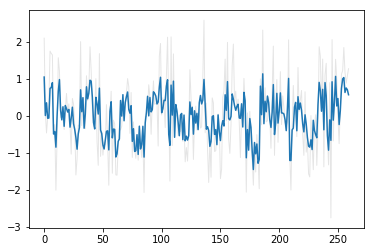

In [1002]:
figsize(6, 4)
for g in range(G):
    plt.plot(range(Y.shape[1]), Y[g], lw=1, c='k', alpha=0.1)
    
plt.plot(m);

In [1003]:
# Expectation of ln P(mu)
def ln_P_mu(mu, K):
    N = K.shape[0]
    C = mu.shape[1]
    ll = 0
    for k in range(C):
        ll = ll + np.linalg.det(K)
        ll = ll + mu[:, k].dot(np.linalg.solve(K, mu[:, k]))
        ll = ll + N * np.log(2 * np.pi)
        
    ll = -0.5 * ll
    
    return ll

In [1004]:
s2e = 1.
l = 1.
K = base.SE_kernel(X, l) + 1e-8 * np.eye(N)
m = Q_mu_expectation(r, Y, K, s2e)
for l in np.logspace(-1, 2, 20):
    K = base.SE_kernel(X, l) + 1e-8 * np.eye(N)
#     m = Q_mu_expectation(r, Y, K, s2e)
#     print(ELBO(Y, r, m, s2e, K))
    print(ln_P_mu(m, K), l)

-281.423190614 0.1
-281.423190528 0.143844988829
-281.421150524 0.206913808111
-280.972613169 0.297635144163
-274.788162327 0.428133239872
-263.636832644 0.615848211066
-258.304152262 0.88586679041
-286.676860203 1.2742749857
-16943.0299053 1.83298071083
-12698784.245 2.63665089873
-145587701.672 3.79269019073
-463205519.424 5.45559478117
-752393553.46 7.84759970351
-935259206.198 11.2883789168
-1335912745.99 16.2377673919
-1927077561.63 23.3572146909
-2642289363.1 33.5981828628
-3309820198.58 48.3293023857
-3529056350.44 69.5192796178
-3666662411.74 100.0


In [1005]:
def l_ln_P_mu(log_l):
    K = base.SE_kernel(X, np.exp(log_l)) + 1e-8 * np.eye(N)
    return ln_P_mu(m, K)

In [1006]:
for l in np.logspace(-2, 2, 50):
    l = np.log(l)
    print(l_ln_P_mu(l), grad(l_ln_P_mu)(l), np.exp(l))

-281.423190179 -8.80009972245e-07 0.01
-281.423190317 -6.04258195111e-07 0.0120679264064
-281.423190411 -4.14913363414e-07 0.014563484775
-281.423190476 -2.84899862699e-07 0.0175751062485
-281.423190521 -1.95626199824e-07 0.0212095088792
-281.423190552 -1.34326522153e-07 0.025595479227
-281.423190573 -9.22351597728e-08 0.0308884359648
-281.423190587 -6.33331699263e-08 0.0372759372031
-281.423190597 -4.34876498661e-08 0.0449843266897
-281.423190604 -2.98607454416e-08 0.0542867543932
-281.423190609 -2.05038467876e-08 0.065512855686
-281.423190612 -1.40789429125e-08 0.0790604321091
-281.423190614 -9.66729091709e-09 0.095409547635
-281.423190616 -6.4925968877e-09 0.115139539933
-281.423190593 9.23494848868e-07 0.138949549437
-281.423177486 0.000373722221988 0.167683293681
-281.421895493 0.0269362347015 0.202358964773
-281.386478019 0.55249467932 0.244205309455
-281.017592115 4.35095383889 0.294705170255
-279.206735192 16.5233603836 0.355648030622
-274.715608719 29.3800621303 0.429193426013

In [1007]:
# Expecation of ln Q(mu)
def ln_Q_mu(K, Z, s2e):
    N = K.shape[0]
    C = Z.shape[1]
    G_k = Z.sum(0)
    
    ll = 0
    U, S = base.factor(K)
    for k in range(C):
        ll = ll - (1. / S + G_k[k] / s2e).sum()
        ll = ll + N * np.log(2 * np.pi)
        
    
    ll = -0.5 * ll
    
    return ll

In [1008]:
l = 1.
s2e_0 = 1.
K0 = base.SE_kernel(X, l) + 1e-8 * np.eye(N)
m = Q_mu_expectation(r, Y, K0, s2e)

elbojective = make_elbojective(Y, r, m, X, K0, s2e_0)

for l in np.logspace(-2, 2, 20):
    K = base.SE_kernel(X, l) + 1e-4 * np.eye(N)
    l = np.log(l)
    x = np.array([l, 0.])
    print(-elbojective(x), grad(elbojective)(x)[0], np.exp(l))
    print('{}\t{}\t{}'.format(ln_P_YZms(Y, r, m, 1.), ln_P_mu(m, K), ln_P_Z(r)))
    print('{}\t{}\t{}'.format(ln_P_YZms(Y, r, m, 1.), -ln_Q_mu(K0, r, s2e_0), -ln_Q_Z(r, r)))
    print()

-2681.79869603 8.80009972245e-07 0.01
-285.8353422727102	-281.43215959173926	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.79869631 3.3376091731e-07 0.0162377673919
-285.8353422727102	-281.4321598754751	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.79869641 1.26585233015e-07 0.0263665089873
-285.8353422727102	-281.43215998308744	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.79869645 4.80098653975e-08 0.0428133239872
-285.8353422727102	-281.4321600239015	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.79869647 1.82086557408e-08 0.0695192796178
-285.8353422727102	-281.43216003938096	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.79869647 6.86121214765e-09 0.112883789168
-285.8353422727102	-281.4321600452512	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.79855822 -0.00339090286685 0.183298071083
-285.8353422727102	-281.4320218224036	0.0
-285.8353422727102	-2114.5401635833746	-0.0

-2681.34811902 -4.74642962651 0.297635144163
-285.835342272

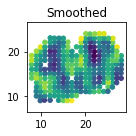

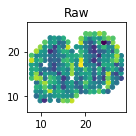

In [1020]:
l = 1.5
s2e_0 = 1.
K0 = base.SE_kernel(X, l) + 1e-8 * np.eye(N)
m = Q_mu_expectation(r, Y, K0, s2e)

figsize(2, 2)
for k in np.unique(r.argmax(1)):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=(m[:, k]), s=20)
    plt.axis('equal')
    plt.title('Smoothed'.format(k + 1))
    plt.tight_layout()
    
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y[0], s=20)
plt.axis('equal')
plt.title('Raw')
plt.tight_layout()

In [730]:
from scipy import optimize

In [992]:
def fit_patterns(C, Y, X, l, s2e, print_elbo=False, maxiter=10, printerval=1, opterval=1, lr=1e-4):
    G = Y.shape[0]
    N = Y.shape[1]
    eps = 1e-8 * np.eye(N)
    
    l_init = l
    s2e_init = s2e
    
    l_min, l_max = base.get_l_limits(X)
    l_min, l_max = l_min * 4, l_max / 1
    
    r = np.random.uniform(size=(G, C))
    r = r / r.sum(0)
    
    pi = r.sum(0) / G

    K = base.SE_kernel(X, l) + eps

    m = np.random.normal(size=(N, C))
    
    elbo_0 = ELBO(Y, r, m, s2e, K, K, s2e, pi)

    if print_elbo:
        print('iter ', 0, 'ELBO: ', elbo_0)

    fgrad = np.array([np.nan, np.nan])
    
    x0 = np.array([np.log(l_init), np.log(s2e_init)])
    x = x0
    for i in range(maxiter):
        if (i % opterval == (opterval - 1)):
            elbojective = make_elbojective(Y, r, m, X, K, s2e, pi)
            fgrad = grad(elbojective)(x)
            
            x = x - lr * fgrad
            
#             o = optimize.minimize(elbojective, x,
#                                   method='L-BFGS-B',
#                                   jac=grad(elbojective),
#                                   bounds=[(np.log(l_min), np.log(l_max)),
#                                           (-4., 0.)])
#             x = o.x
                        
            l = np.clip([np.exp(x[0])], l_min, l_max)[0]
            s2e = np.min([np.exp(x[1]), 10.])
            
            K = base.SE_kernel(X, l) + eps
            
            
        r = Q_Z_expectation(m, Y, s2e, N, C, G, pi)
        m = Q_mu_expectation(r, Y, K, s2e)
        
        pi = r.sum(0) / G

        if print_elbo and (i % printerval == 0):
            print('iter ', i + 1,
                  'ELBO: ', ELBO(Y, r, m, s2e, K, K, s2e, pi), 
                  'l: {:0.2f}'.format(np.log(l)),
                  's2e: {:.2f}'.format(np.log(s2e)),
                  'dl: {:2.2e}'.format(fgrad[0]),
                  'ds2e: {:2.2e}'.format(fgrad[1])
                 )
            print('P(Y|Z,mu,s2e): ', ln_P_YZms(Y, r, m, s2e, pi),
                  ', P(Z): ', ln_P_Z(r, pi),
                  ', P(mu): ', ln_P_mu(m, K))
            print('Q(Z): ', ln_Q_Z(r, r), ', Q(mu)', ln_Q_mu(K, r, s2e))
            print()


    return ELBO(Y, r, m, s2e, K, K, s2e, pi), m, r, s2e, l

In [993]:
Y = res[sres['g']].values.T

# This is important
Y = (Y.T - Y.mean(1)).T
Y = (Y.T / Y.std(1)).T

C = 5
elbo, m, r, s2e, l = fit_patterns(C, Y, X, 1., 0.5, True, maxiter=500, printerval=41, opterval=2, lr=1e-4)

K = base.SE_kernel(X, l)

iter  0 ELBO:  -28263.3369587
iter  1 ELBO:  -58574.0939735 l: 0.00 s2e: -0.69 dl: nan ds2e: nan
P(Y|Z,mu,s2e):  -29732.9346647 , P(Z):  -95.4202281532 , P(mu):  -1405.57689924
Q(Z):  -2.53863653777 , Q(mu) 27342.7008179

iter  42 ELBO:  -51197181.8909 l: 0.47 s2e: 2.30 dl: -2.24e+01 ds2e: -4.47e+02
P(Y|Z,mu,s2e):  -16719.565789 , P(Z):  -77.9018916433 , P(mu):  -1226.05594296
Q(Z):  -7.72807818626 , Q(mu) 51179166.0954

iter  83 ELBO:  -51197181.8905 l: 0.47 s2e: 2.30 dl: -1.89e+01 ds2e: -2.34e+02
P(Y|Z,mu,s2e):  -16719.547465 , P(Z):  -77.9019063346 , P(mu):  -1226.06185892
Q(Z):  -7.7161488856 , Q(mu) 51179166.0954

iter  124 ELBO:  -51197181.8905 l: 0.47 s2e: 2.30 dl: -1.58e+01 ds2e: -1.56e+02
P(Y|Z,mu,s2e):  -16719.5474649 , P(Z):  -77.9019063448 , P(mu):  -1226.06185892
Q(Z):  -7.71614888325 , Q(mu) 51179166.0954

iter  165 ELBO:  -51197181.8905 l: 0.47 s2e: 2.30 dl: -1.33e+01 ds2e: -1.19e+02
P(Y|Z,mu,s2e):  -16719.5474649 , P(Z):  -77.9019063448 , P(mu):  -1226.06185892
Q(Z):  -

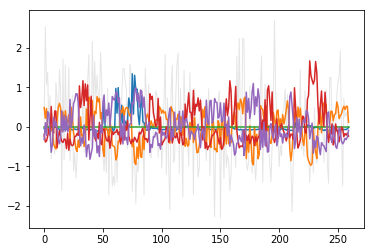

In [994]:
figsize(6, 4)
for g in range(G):
    plt.plot(range(Y.shape[1]), Y[g], lw=1, c='k', alpha=0.1)
    
plt.plot(m);

In [995]:
# figsize(6, 4)
# for g in range(G):
#     plt.plot(range(Y.shape[1]), Y[g], lw=1, c='k', alpha=0.1)
    
# plt.plot(K.dot(m));

In [996]:
sres['pattern'] = r.argmax(1)

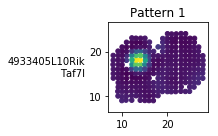

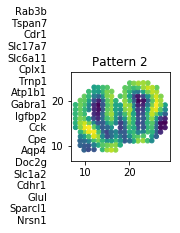

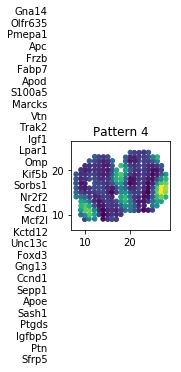

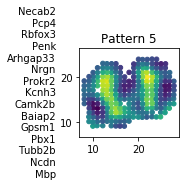

In [997]:
figsize(2, 2)
for k in np.unique(r.argmax(1)):
    plt.figure()
#     plt.scatter(X[:, 0], X[:, 1], c=K.dot(m[:, k]), s=20)
    plt.scatter(X[:, 0], X[:, 1], c=(m[:, k]), s=20)
    plt.axis('equal')
    plt.title('Pattern {}'.format(k + 1))
    plt.tight_layout()
    plt.ylabel('\n'.join(sres.query('pattern == @k')['g']), rotation=0, va='center', ha='right')